In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=587fd8920c0d6b21a48c2a7f228a41b97b1a63d8bf50c23a7431f944f9ec23b0
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import scvi

In [ ]:
import scanpy as sc

In [ ]:
adata = sc.read("/content/cassandra_hvg.h5")

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key=None)

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [ ]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=10, gene_likelihood="nb")

In [ ]:
model.train()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [ ]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()


In [ ]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)


In [ ]:
for i in range(10):
  adata.obs["scVI_"+str(i)] = adata.obsm["X_scVI"][:,i]

In [ ]:
adata.X = adata.layers["counts"]

In [ ]:
SCVI_MDE_KEY = "X_scVI_MDE"
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cpu for `pymde.preserve_neighbors`.                                                                 


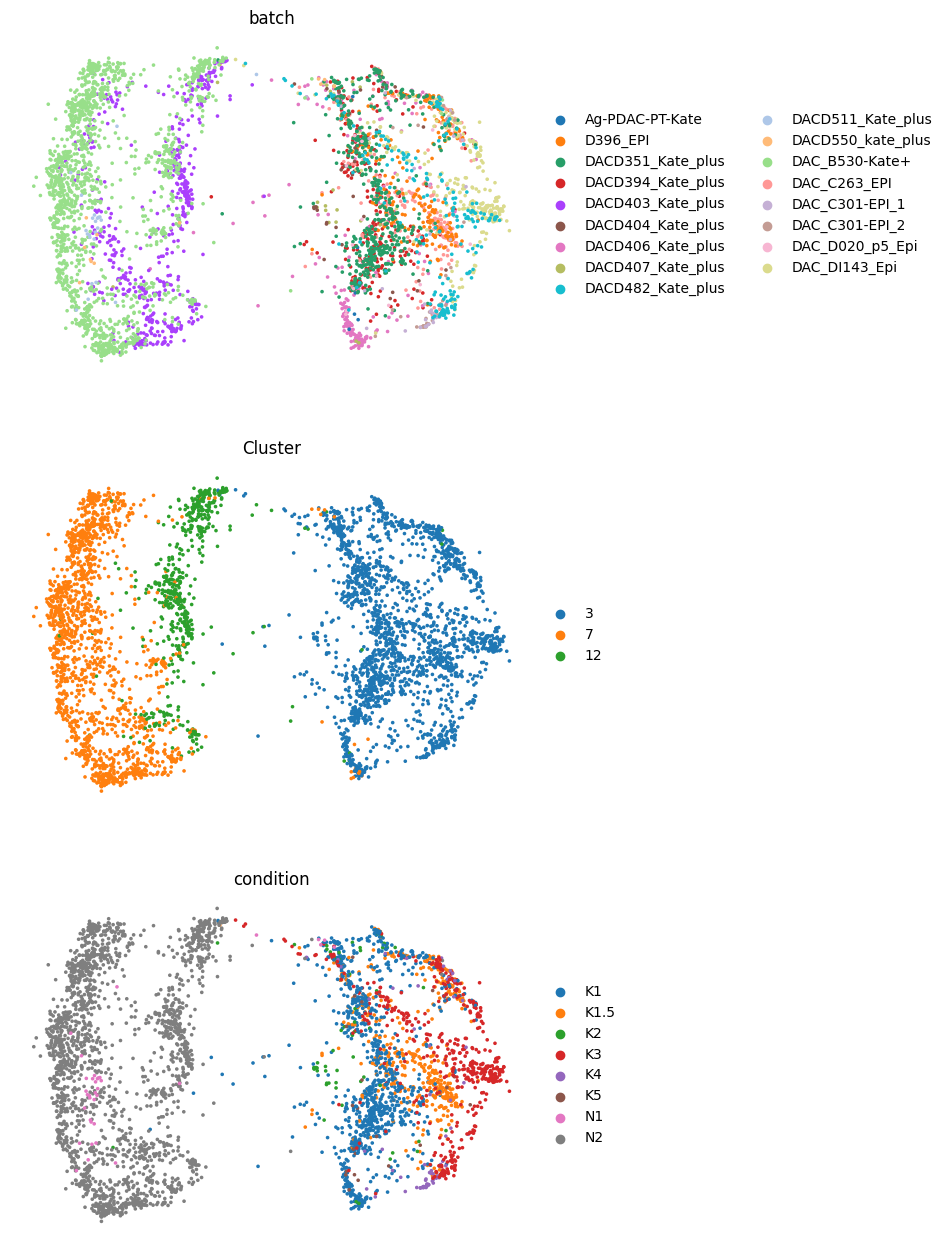

In [ ]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["batch", "Cluster","condition"],
    frameon=False,
    ncols=1,
    #save = 'scvi.pdf'
)

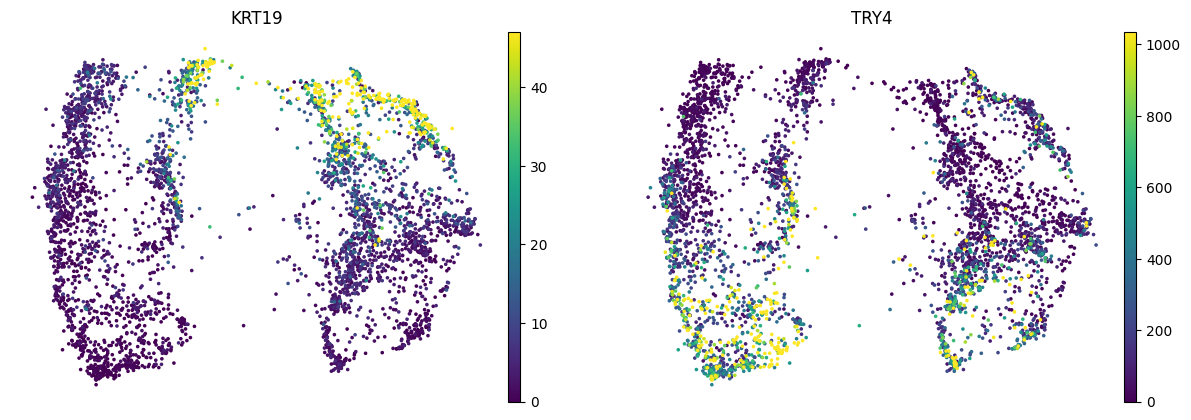

In [ ]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['KRT19', 'TRY4'],
    frameon=False,
    ncols=4,
    vmax="p95",
    save="scVI_markers.pdf")

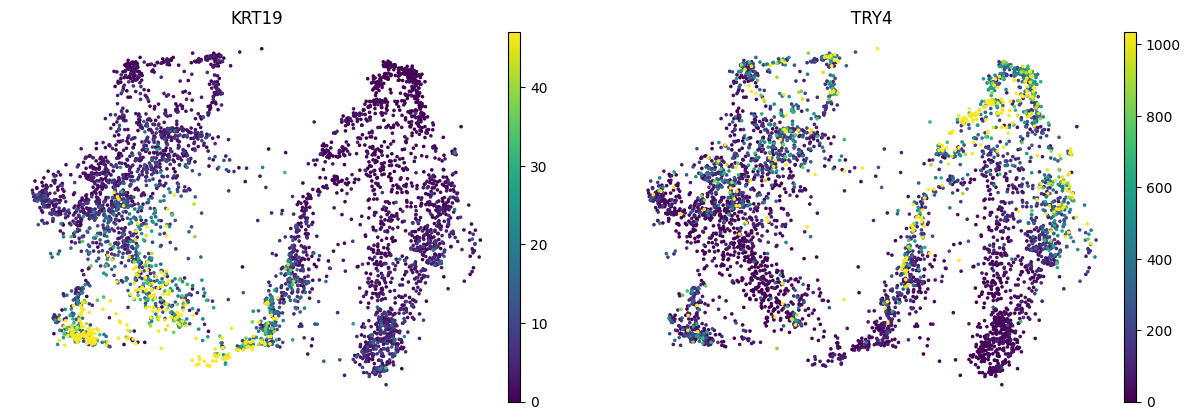

In [ ]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['KRT19', 'TRY4'],
    frameon=False,
    ncols=4,
    vmax="p95",
    save="scVI_markers.pdf")

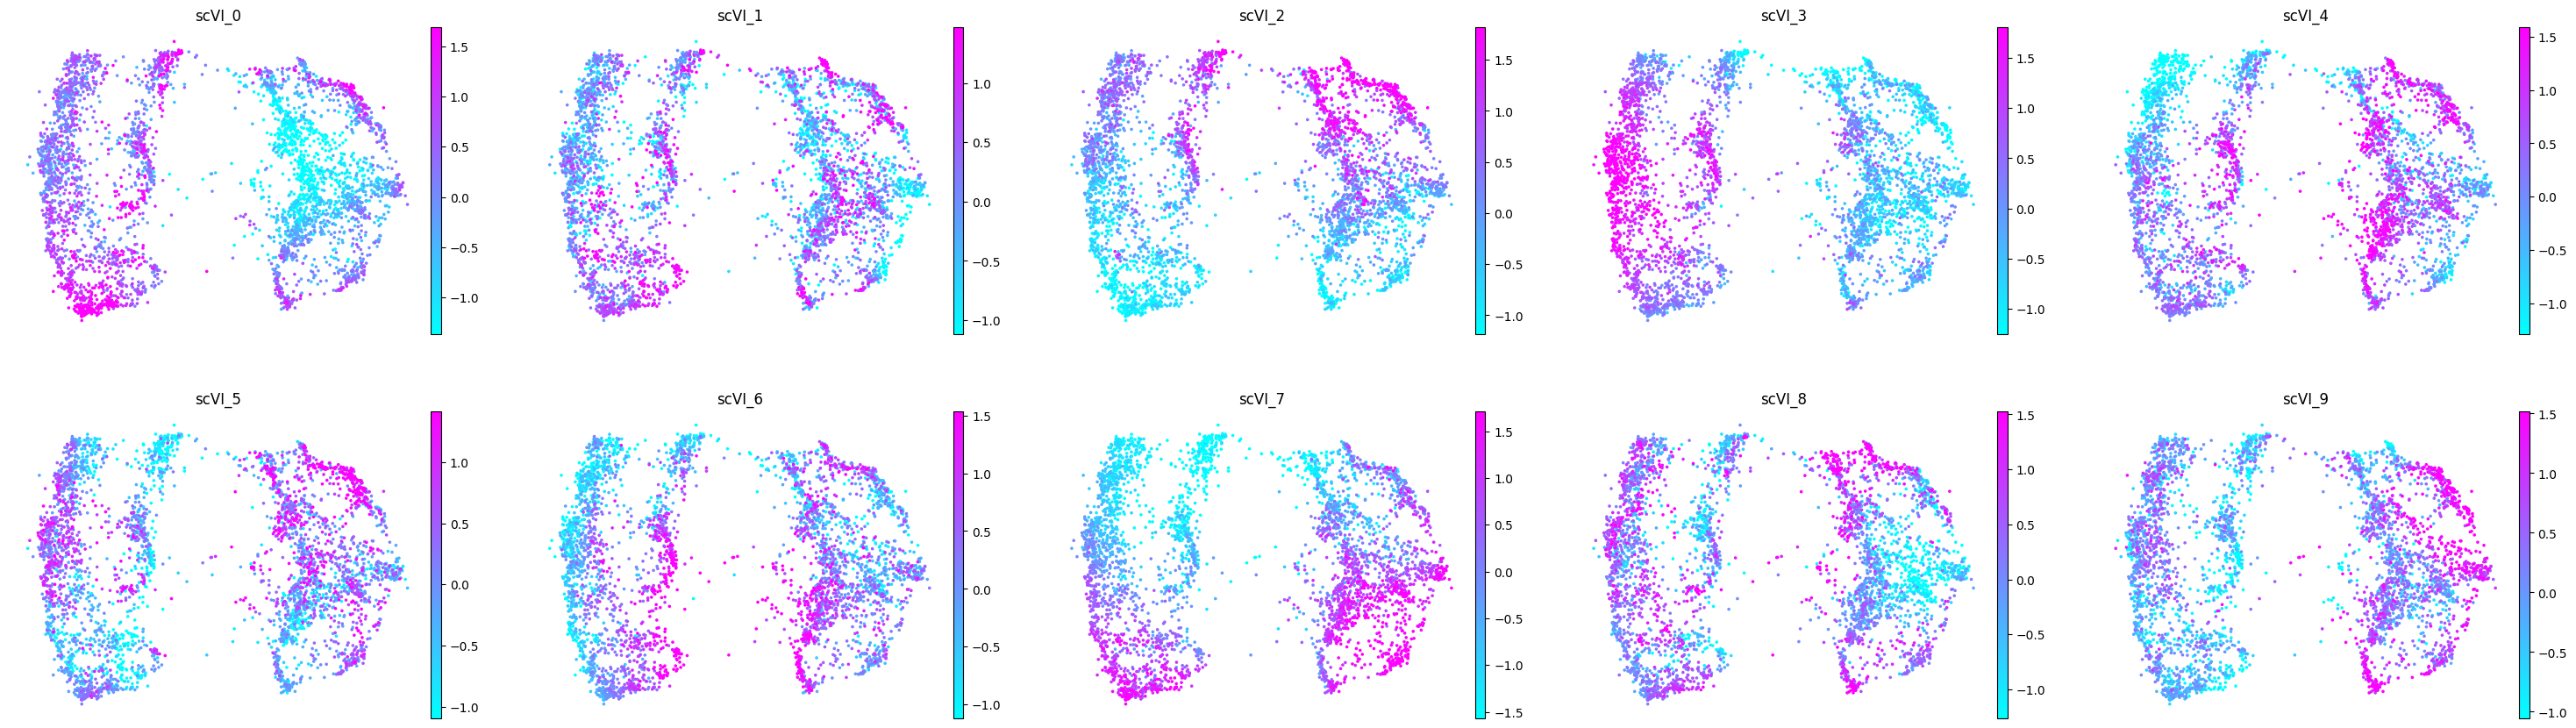

In [ ]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["scVI_"+str(i) for i in range(10)],
    frameon=False,
    ncols=5,
    vmin="p10",
    vmax="p95",
    cmap='cool',
    save='scvi_z'
)

In [ ]:
adata.write_h5ad("/content/scvi_cassandra_pdac_no_batch_correction.h5")

In [ ]:
adata = sc.read_h5ad("/content/sample_data/scvi_cassandra_pdac_no_batch_correction.h5")

In [ ]:
import pandas as pd
import numpy as np
ad_normed = adata.to_df()
def get_cov(thing):
    covs = pd.DataFrame()
    for gene in ad_normed.columns:
        tmp = pd.DataFrame({gene:[np.corrcoef([ad_normed[gene],thing])[0,1]]})
        covs = pd.concat((covs, tmp),axis=1)
    return covs.T

z_Cov = {}
z = adata.obsm["X_scVI"]
for i in range(10):
    z_tmp = get_cov(z[:,i])
    z_Cov[i]=z_tmp

z_cov = pd.DataFrame()
for key in z_Cov.keys():
    z_cov[key] = z_Cov[key]


In [ ]:
import scipy
z_df = pd.DataFrame(z, index=adata.obs_names)

obs = adata.obs
kras = obs[obs["Cluster"]=='3'].index
not_kras = obs[obs["Cluster"]!='3'].index

t_tests = pd.DataFrame()
for i in range(10):
    t_tests[i] = scipy.stats.ttest_ind(z_df.loc[kras][i],z_df.loc[not_kras][i])

In [ ]:
t_tests.T

0              1
0 -45.764137   0.000000e+00
1  -7.344290   2.452725e-13
2  15.343554   8.453770e-52
3 -61.050733   0.000000e+00
4  21.989349  9.394810e-102
5  15.904577   2.023744e-55
6   8.038473   1.159484e-15
7  25.054367  1.340547e-129
8  -5.616828   2.065082e-08
9  31.326853  1.311647e-194

In [ ]:
t_tests.T

0              1
0  -0.883905   3.767959e-01
1  24.329811  9.137564e-123
2   6.951470   4.147454e-12
3  35.894094  1.207154e-247
4 -23.751798  2.008700e-117
5  -2.700628   6.947423e-03
6   6.716496   2.099079e-11
7  12.196133   1.135991e-33
8  -6.603608   4.490266e-11
9  59.681069   0.000000e+00

In [ ]:
z_cov.to_csv("scvi_z_cov.csv")

In [ ]:
z8_high = pd.DataFrame(z_cov[8]).sort_values(by=8,ascending=True).iloc[0:50].index
z7_low = pd.DataFrame(z_cov[7]).sort_values(by=7,ascending=True).iloc[0:50].index
z2_low = pd.DataFrame(z_cov[2]).sort_values(by=2,ascending=True).iloc[0:50].index

In [ ]:
np.intersect1d(z8_high, z6_low)

array([], dtype=object)

In [ ]:
z6_low = ['JUN', 'JUNB', 'RBM39', 'SPP1', 'FOS', 'CTSL', 'MIA', 'IER2', 'GKN3',
       'SON', 'KLF6', 'HSPA5', 'BTG2', 'RHOB', 'UBC', 'CTSE', 'RBP4', 'LMO4',
       'GHRL', 'EGR1', 'IGFBP7', 'H3F3B', 'GALNT7', 'SFN', 'ZFP36', 'CYR61',
       'SOX9', 'ACTB', 'ZFP36L1', 'SERPINB1A', 'ALCAM', 'SDC1', 'CTNNB1',
       '1810011O10RIK', 'EPCAM', 'S100A6', 'ERRFI1', 'TXNIP', 'HES1', 'GLS2',
       'RGS2', 'FOSB', 'DUSP6', 'CALR', 'SPINT2', 'PFN1', 'JUND', 'GM10334',
       'ANXA4', 'IER3']

In [ ]:

rnk=pd.DataFrame({"genes":z_cov.index,"loading":z_cov.iloc[:,3]}).sort_values(by='loading',ascending=False)
nans_index=[]
for i in rnk.index:
    if "MT-" in rnk["genes"][i] or "RPS" in rnk["genes"][i] or "RPL" in rnk["genes"][i] or pd.isna(rnk["loading"][i]):
        nans_index.append(i)
rnk=rnk.drop(np.unique(nans_index))
rnk.to_csv("scvi_z3.rnk",header=False,index=False,sep="\t")

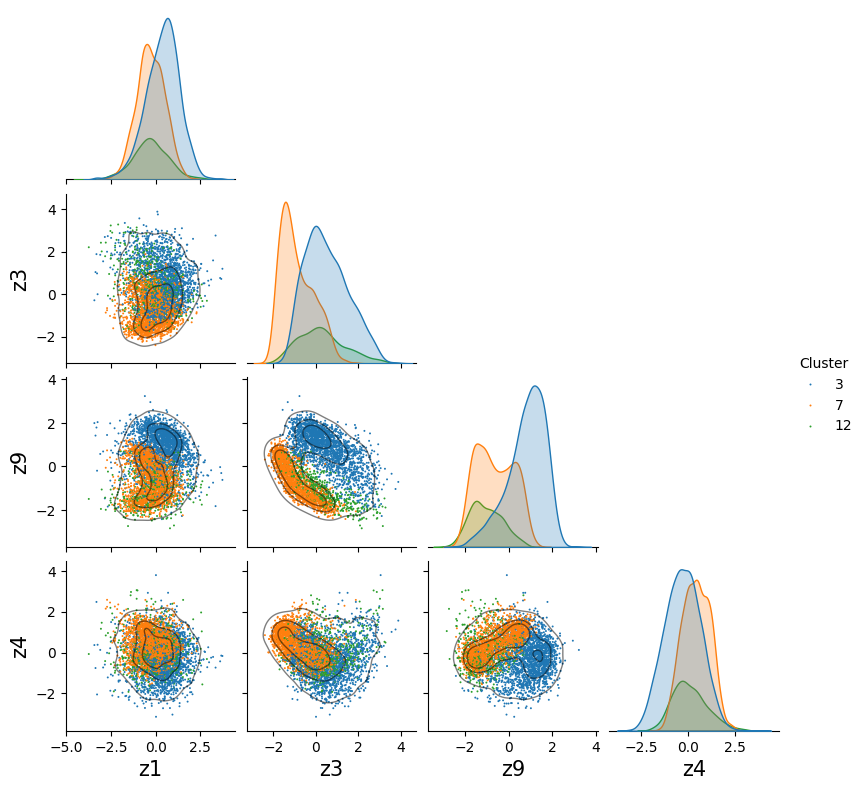

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def f(hue,*args, **kwargs):
    sns.kdeplot(**kwargs)

tmp_data = pd.DataFrame(adata.obsm['X_scVI'], columns=["z%d" % (i) for i in range(10)])
#tmp_data["origin"] = adata.obs["origin"].values
tmp_data["Cluster"] = adata.obs["Cluster"].values

with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':15}):

    pg = sns.pairplot(
        tmp_data,
        x_vars=["z1","z3","z9","z4"],
        y_vars=["z1","z3","z9","z4"],
        corner=True,
        hue="Cluster",
        plot_kws={"s": 2, "linewidth":0, "rasterized":True},
        height=2,
    )
    pg.map_lower(f, levels=4, color="0", alpha=0.5, linewidths=1,)
plt.savefig("figures/scvi_z_corrs_small.pdf")

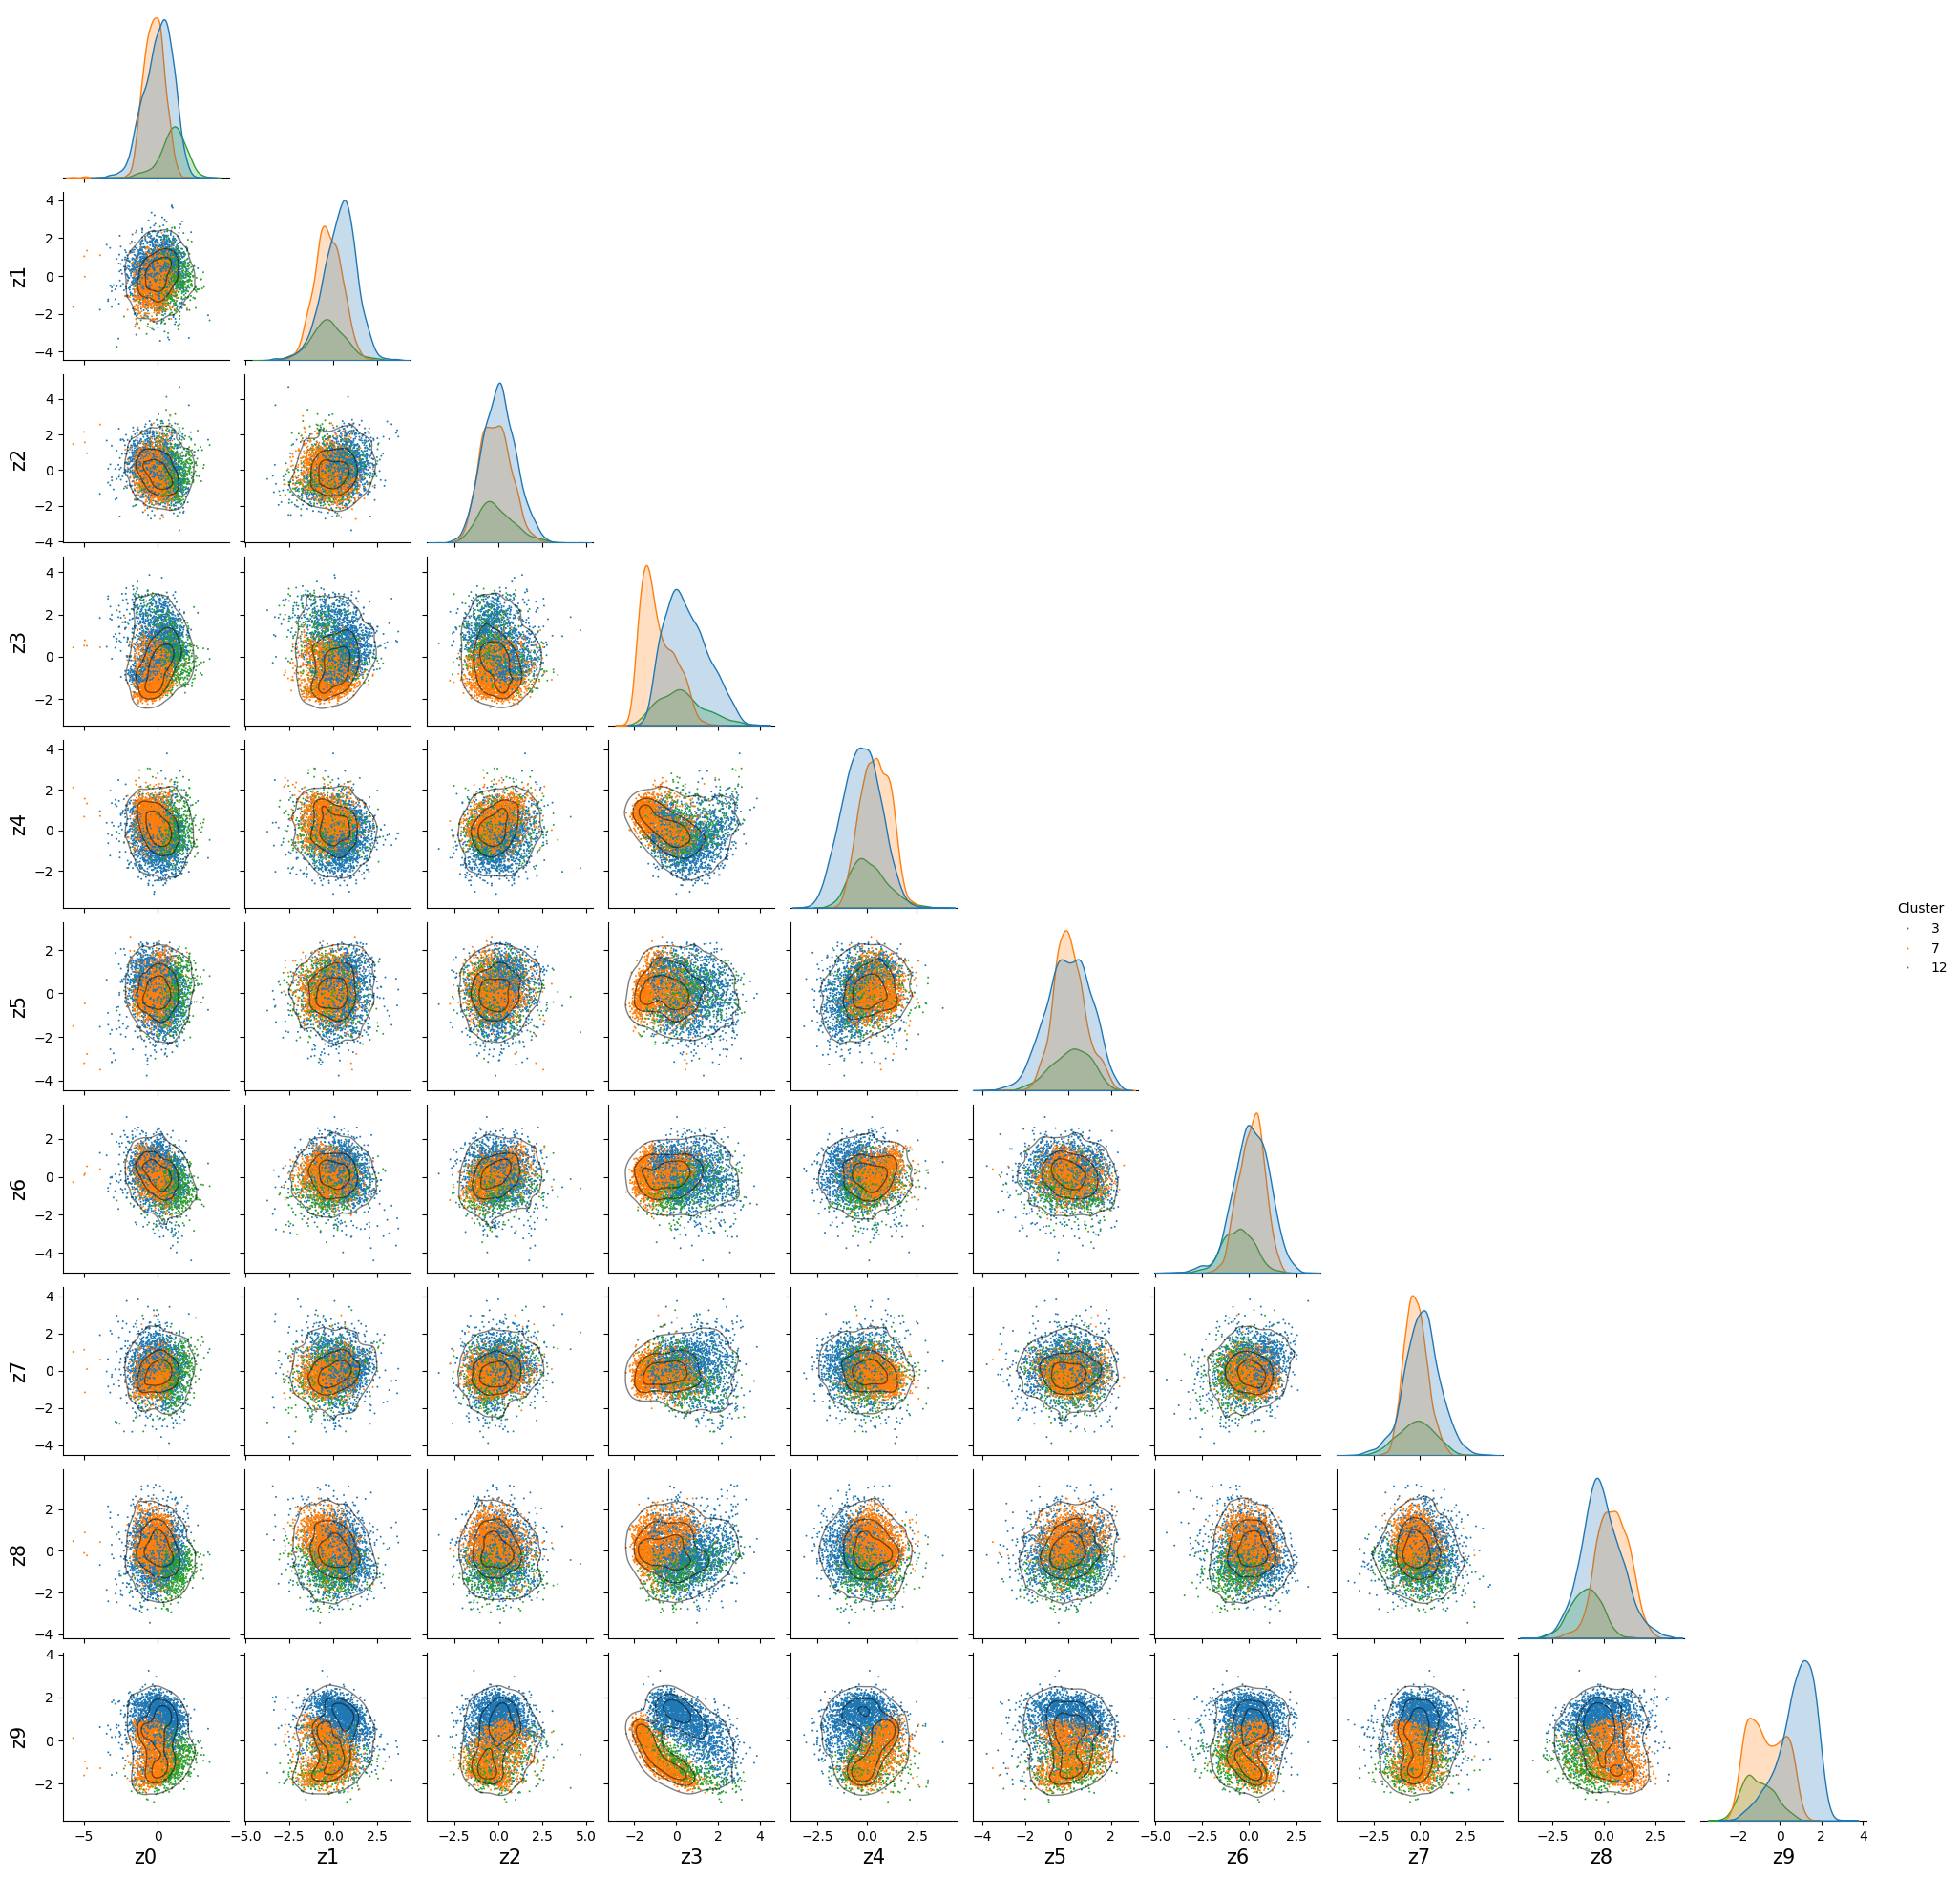

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def f(hue,*args, **kwargs):
    sns.kdeplot(**kwargs)

tmp_data = pd.DataFrame(adata.obsm['X_scVI'], columns=["z%d" % (i) for i in range(10)])
#tmp_data["origin"] = adata.obs["origin"].values
tmp_data["Cluster"] = adata.obs["Cluster"].values

with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':15}):

    pg = sns.pairplot(
        tmp_data,
        x_vars=["z"+str(i) for i in range(10)],
        y_vars=["z"+str(i) for i in range(10)],
        corner=True,
        hue="Cluster",
        plot_kws={"s": 2, "linewidth":0, "rasterized":True},
        height=2,
    )
    pg.map_lower(f, levels=4, color="0", alpha=0.5, linewidths=1,)
plt.savefig("figures/scvi_z_corrs.pdf")